In [1]:
import os
os.chdir('..')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set(style="ticks")

In [2]:
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

In [3]:
%load_ext autoreload

In [4]:
from com.loan import Loan
from com.investor import Investor
from com.backtest import Backtest

In [5]:
from com.lc_helpers import (get_cache_historic)

In [6]:
input_db = get_cache_historic()

In [7]:
dates = sorted(input_db['issue_d'].unique())
dates[0], dates[-1]

(Period('2007-06', 'M'), Period('2015-12', 'M'))

In [8]:
%autoreload com.backtest
from com.backtest import generic_buy_solver, simple_filter_buy_solver

In [22]:
%autoreload Backtest
model_db = input_db[input_db['grade'].isin(['D', 'E', 'F','G'])]
bt = Backtest(dates[12], dates[-1], simple_filter_buy_solver, model_db, cash=1000, liquidity_limit=1.0)

In [23]:
model_db.columns[model_db.columns.str.contains('purpose')]

Index([u'purpose', u'purpose_car', u'purpose_credit_card',
       u'purpose_debt_consolidation', u'purpose_educational',
       u'purpose_home_improvement', u'purpose_house',
       u'purpose_major_purchase', u'purpose_medical', u'purpose_moving',
       u'purpose_other', u'purpose_renewable_energy',
       u'purpose_small_business', u'purpose_vacation', u'purpose_wedding'],
      dtype='object')

In [24]:
result = bt.run()

2008-06 2015-12
available 8
matching 0
solver number 40.0
solver number restricted 0
2008-07 2015-12
available 12
matching 0
solver number 40.0
solver number restricted 0
2008-08 2015-12
available 20
matching 2
solver number 40.0
solver number restricted 2
2008-09 2015-12
available 4
matching 0
solver number 38.0
solver number restricted 0
2008-10 2015-12
available 16
matching 1
solver number 38.0
solver number restricted 1
2008-11 2015-12
available 42
matching 4
solver number 37.0
solver number restricted 4
2008-12 2015-12
available 40
matching 3
solver number 33.0
solver number restricted 3
2009-01 2015-12
available 59
matching 3
solver number 30.0
solver number restricted 3
2009-02 2015-12
available 79
matching 2
solver number 28.0
solver number restricted 2
2009-03 2015-12
available 80
matching 6
solver number 26.0
solver number restricted 6
2009-04 2015-12
available 89
matching 1
solver number 21.0
solver number restricted 1
2009-05 2015-12
available 50
matching 4
solver number 21

In [32]:
bt.stats_dict['sharpe']

2.9170529749344825

In [26]:
# bt.stats.tail(10)

In [27]:
bt.stats.columns

Index([u'abs imbalance', u'abs imbalance %', u'available loans', u'cash held',
       u'cumulative defaults', u'cumulative loans held', u'imbalance',
       u'imbalance %', u'loans added', u'loans held', u'net worth',
       u'strategy available loans', u'defaults', u'monthly return',
       u'annualized return', u'total liquidity', u'strategy liquidity',
       u'strategy vs total liquidity', u'default rate', u'growth of $1'],
      dtype='object')

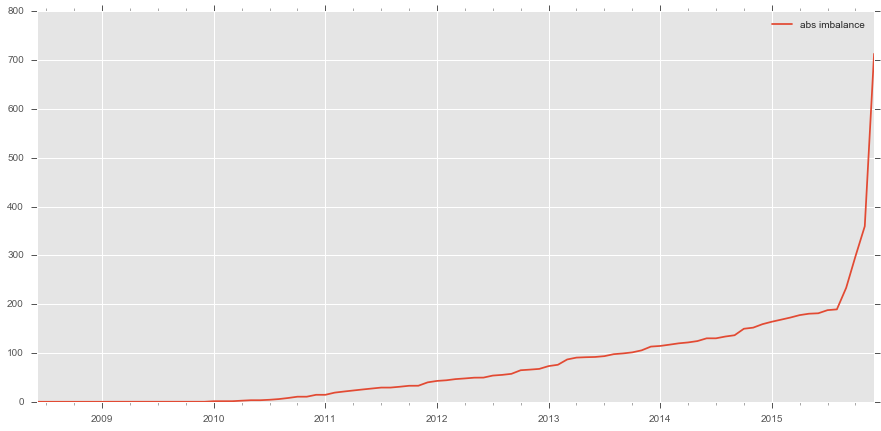

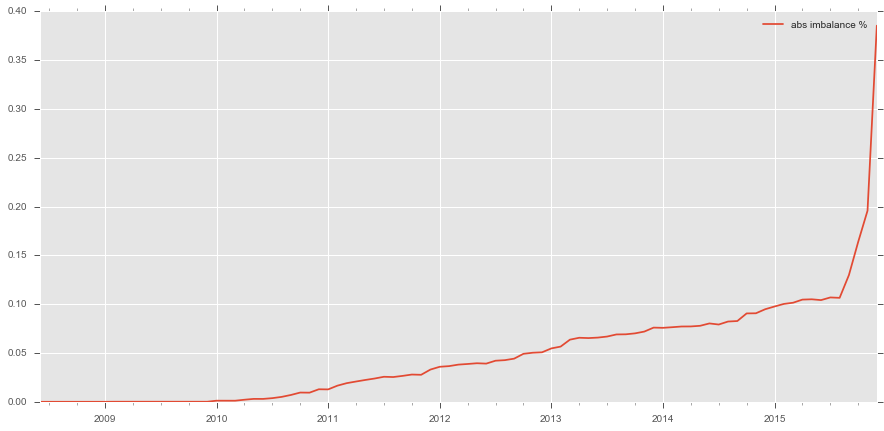

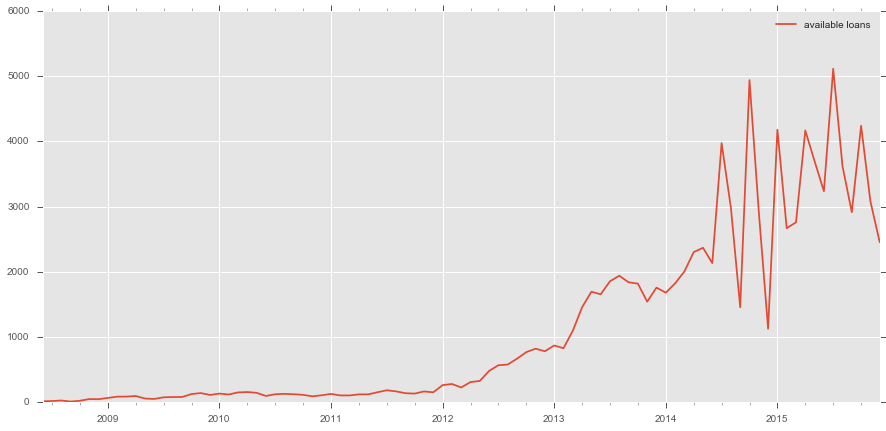

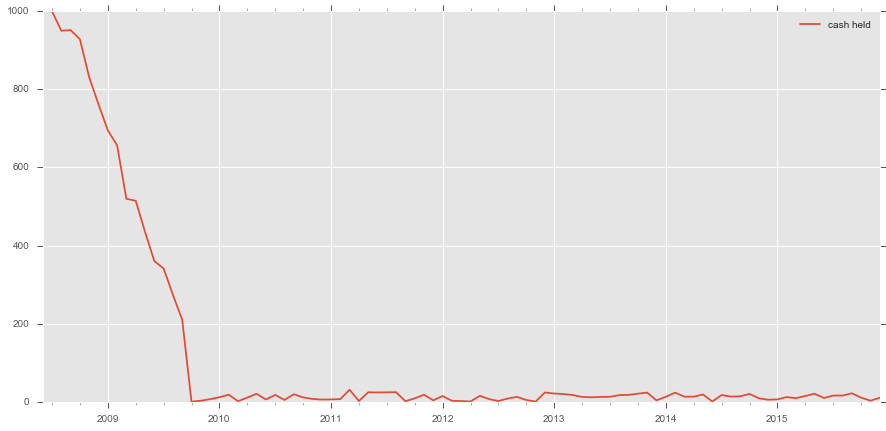

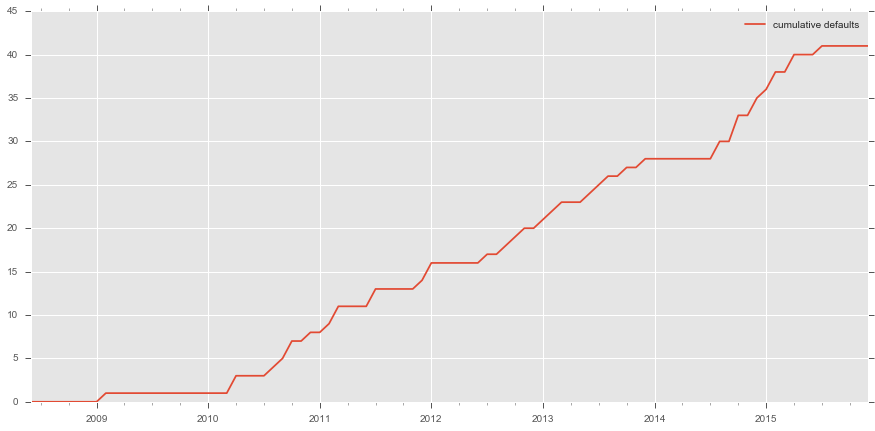

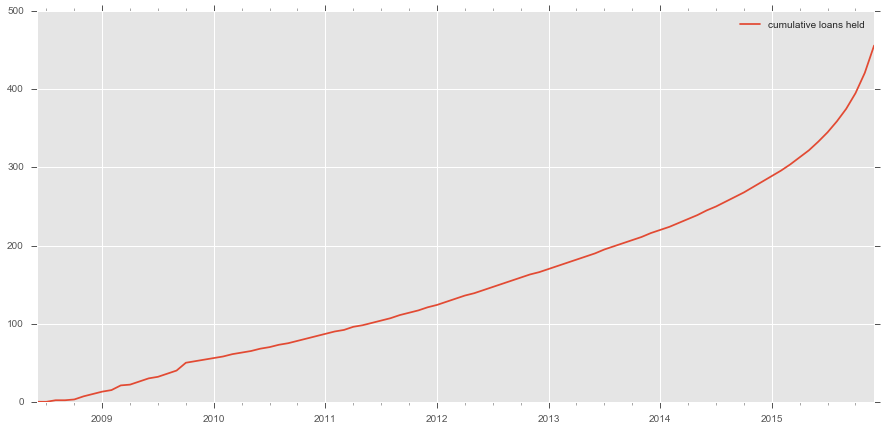

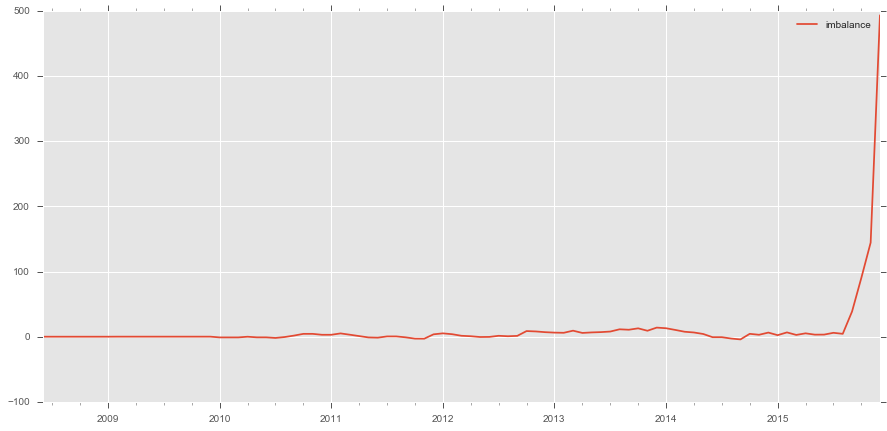

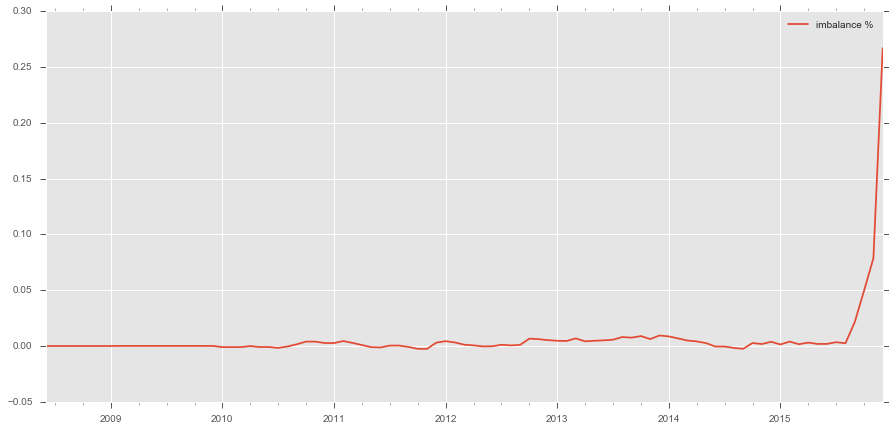

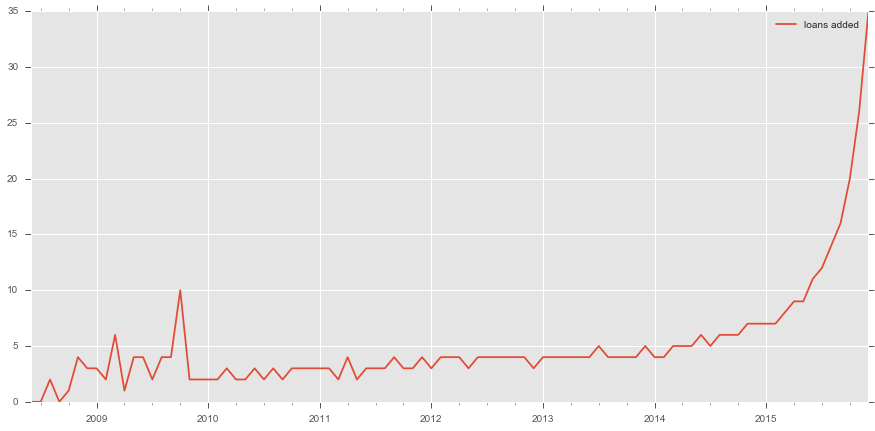

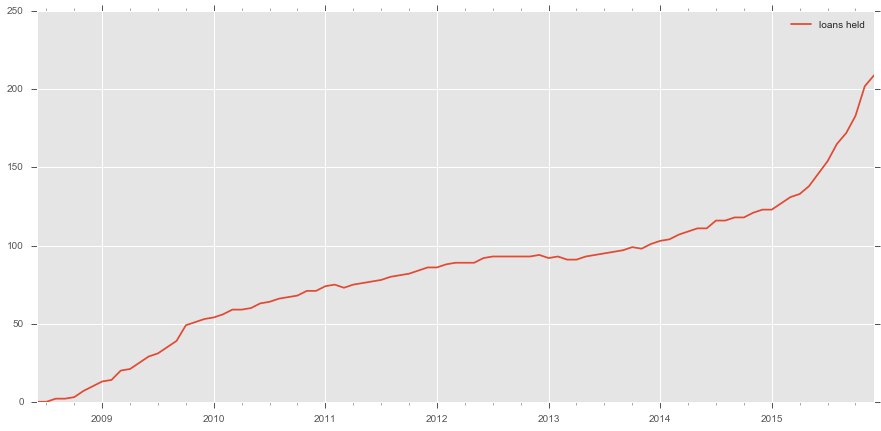

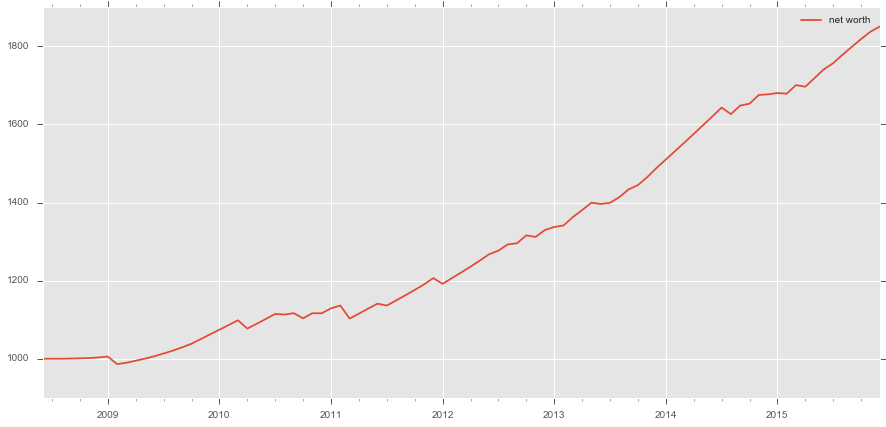

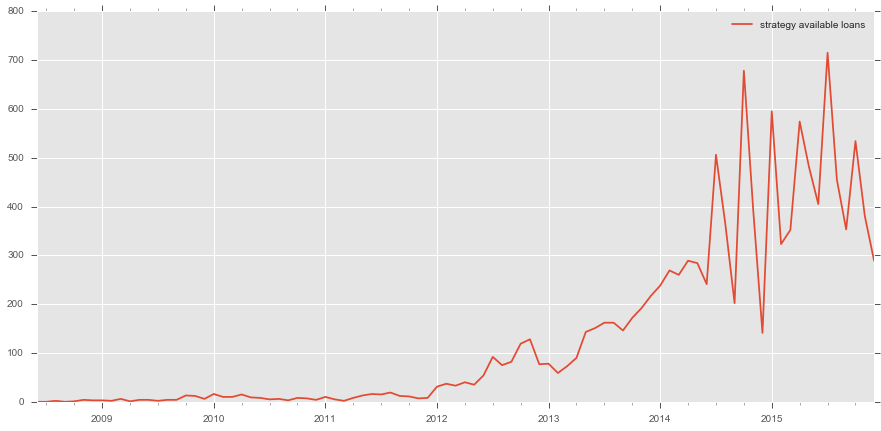

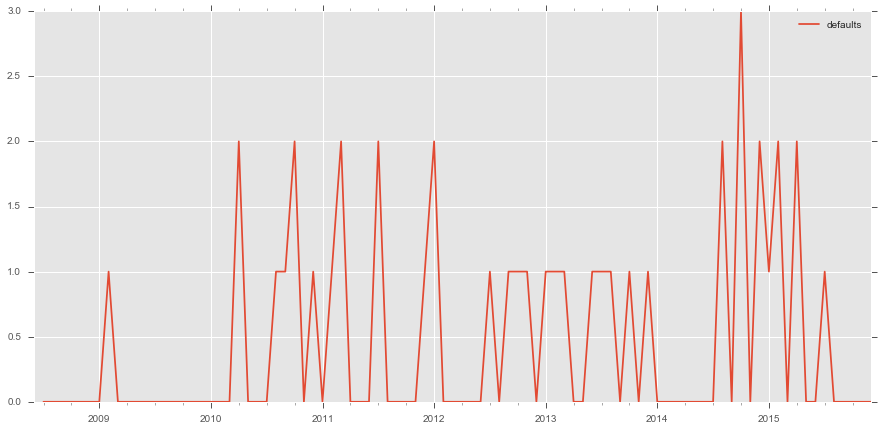

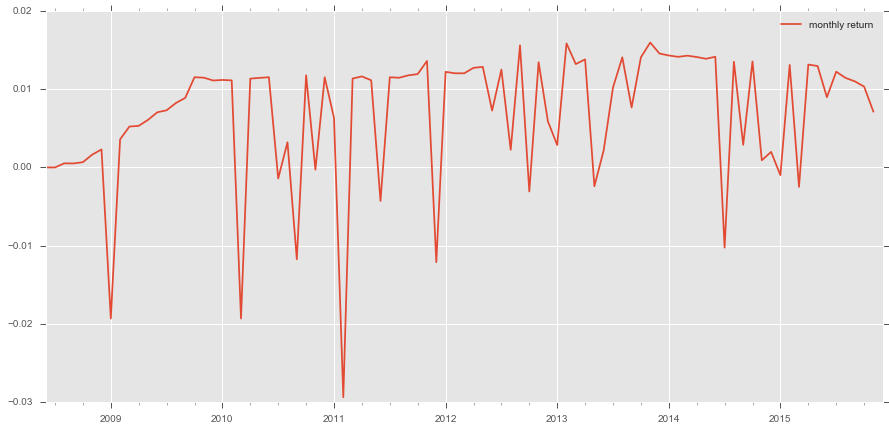

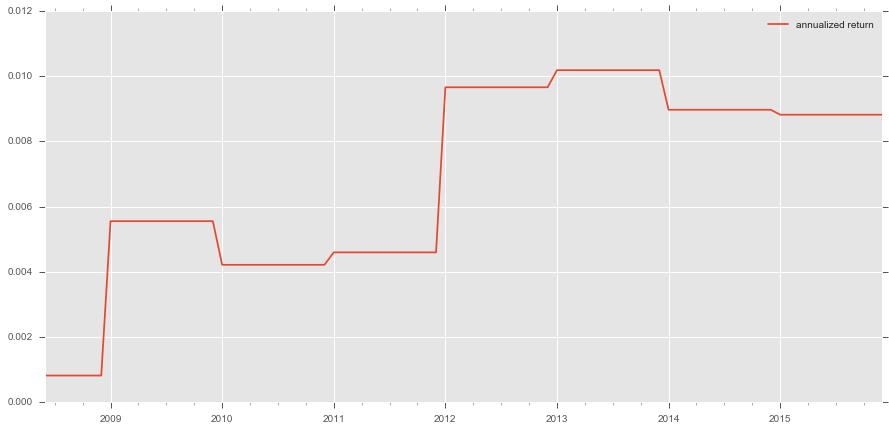

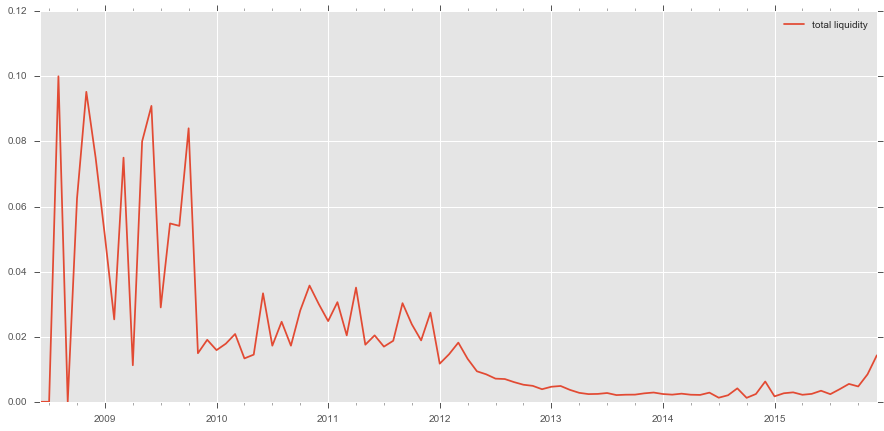

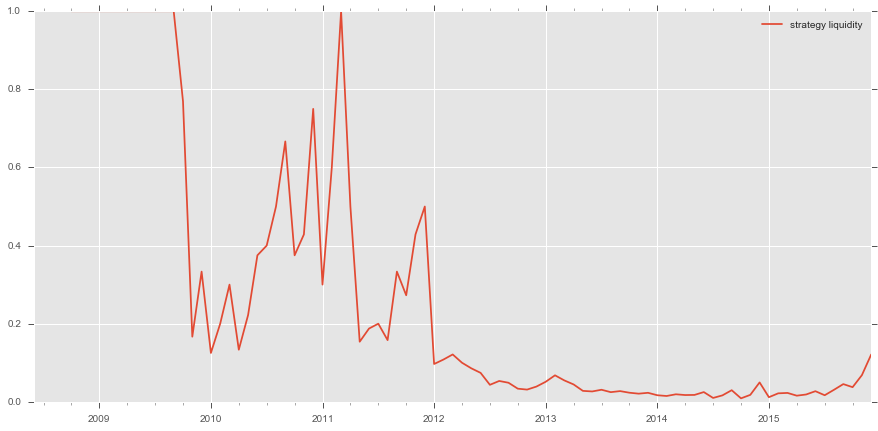

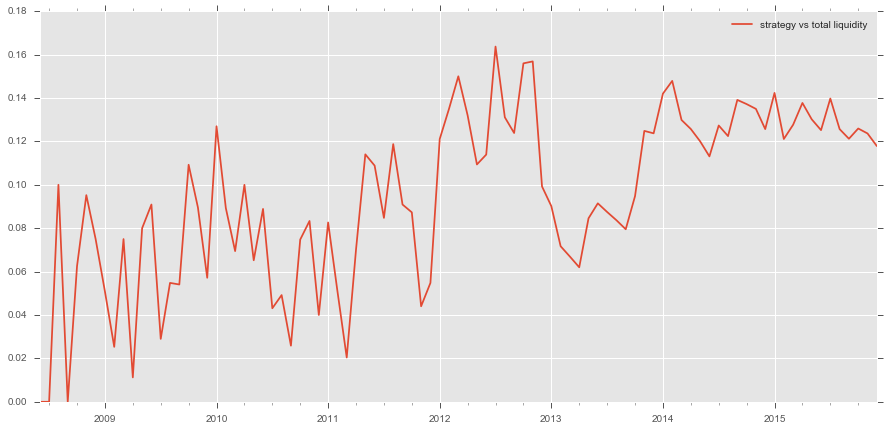

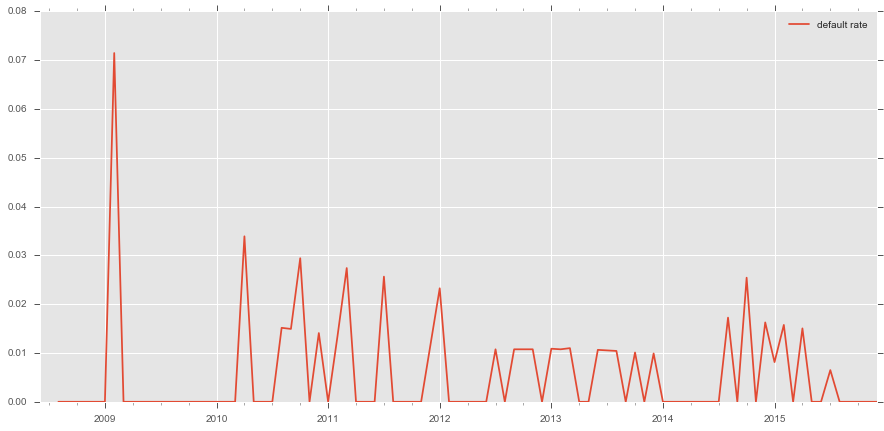

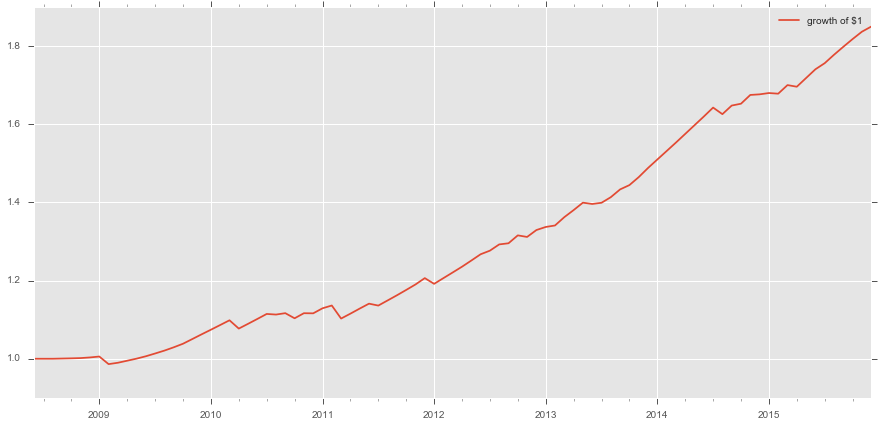

In [28]:
for column in bt.stats.columns:
    bt.stats[column].plot(label=column)
    plt.legend()
    plt.show()

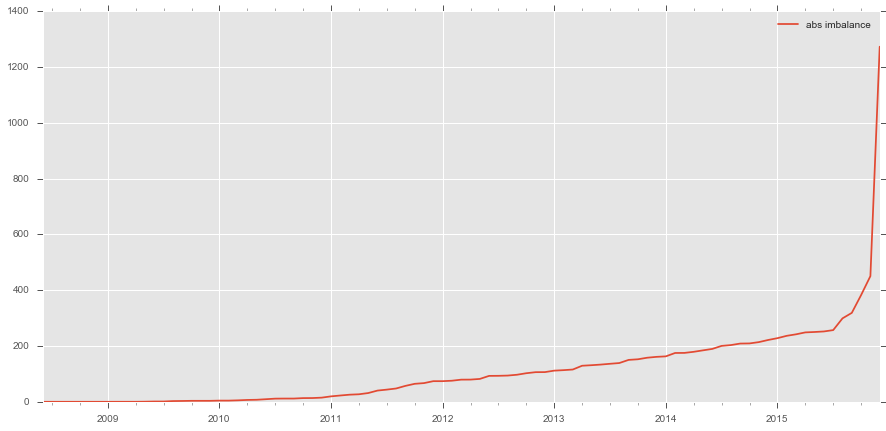

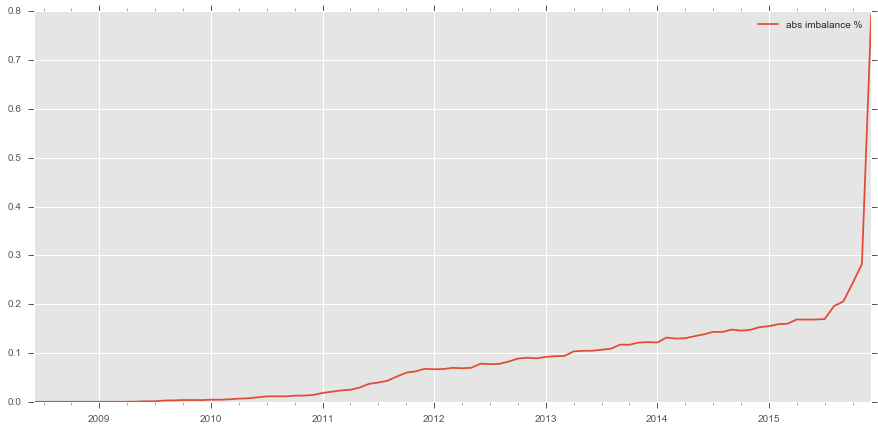

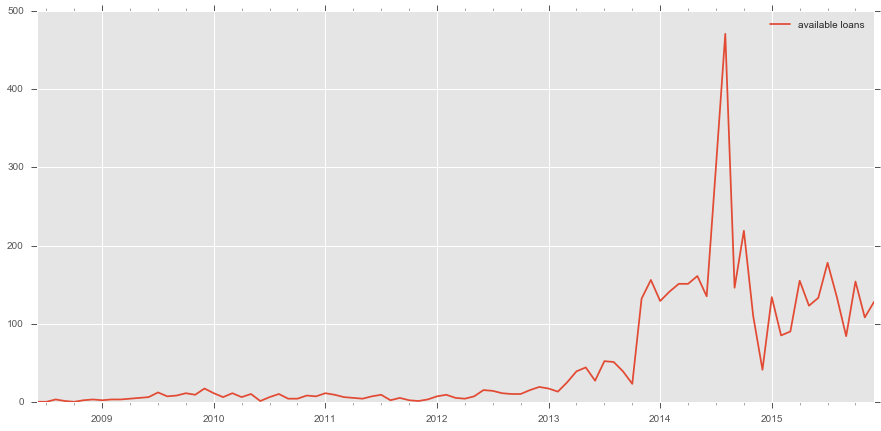

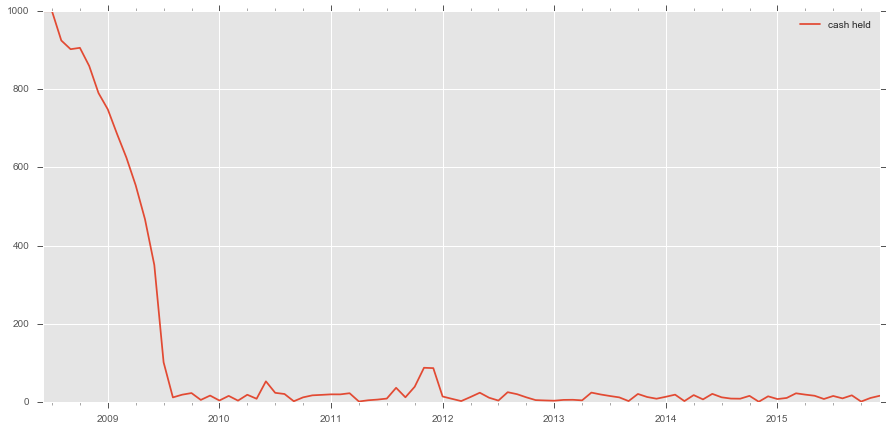

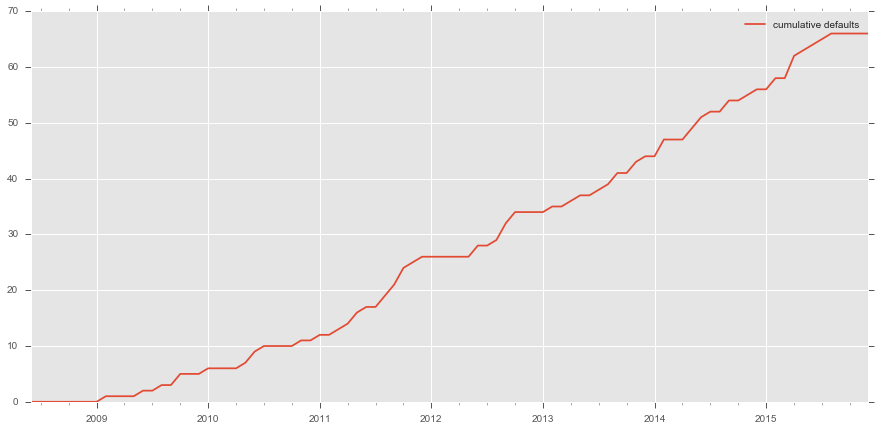

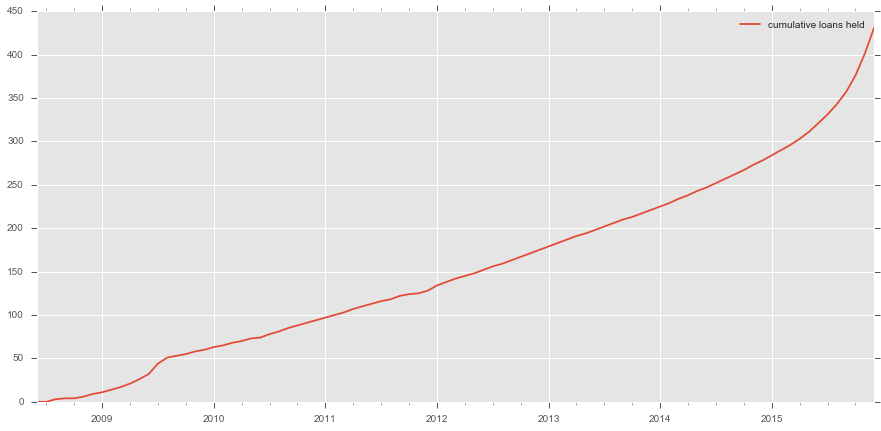

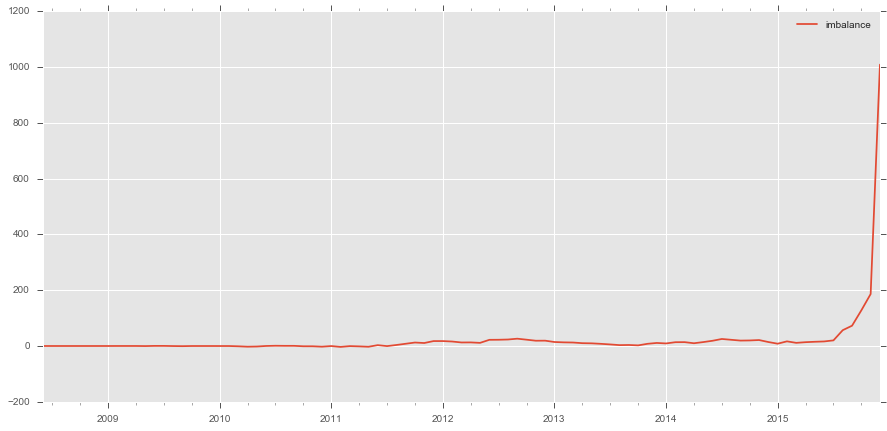

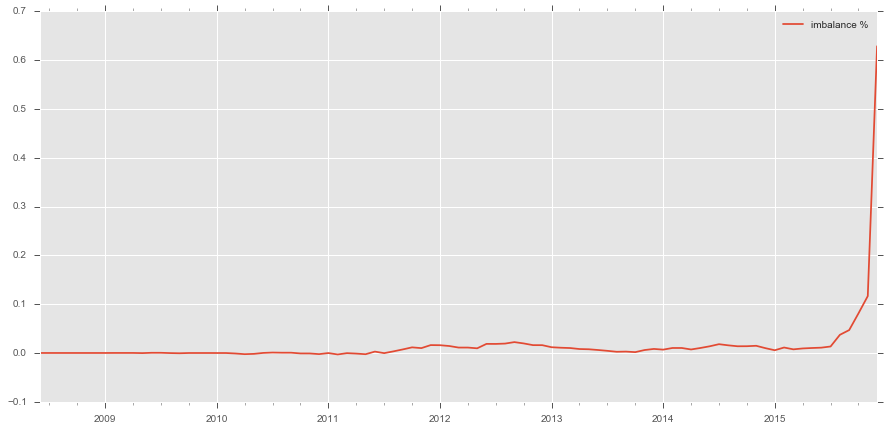

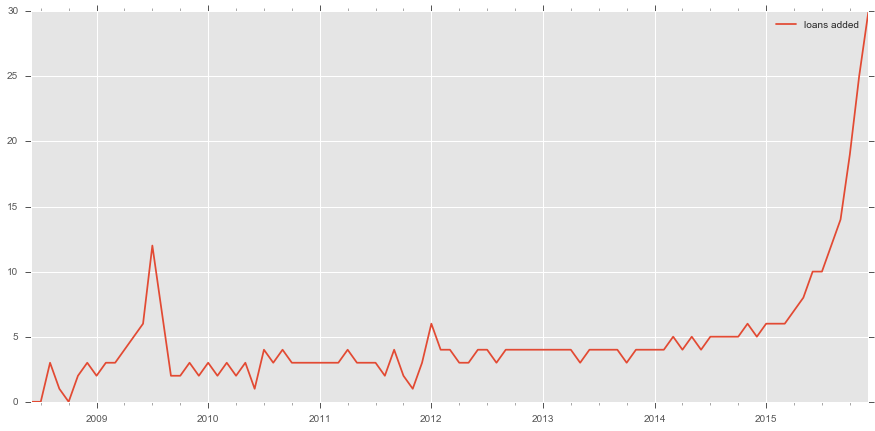

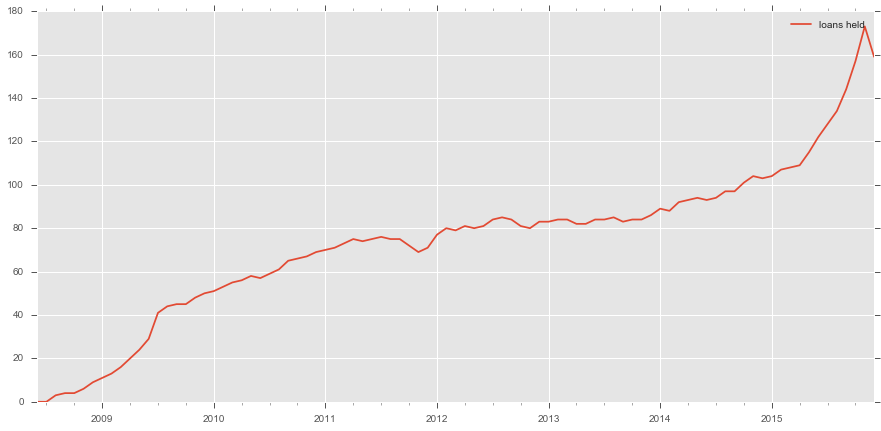

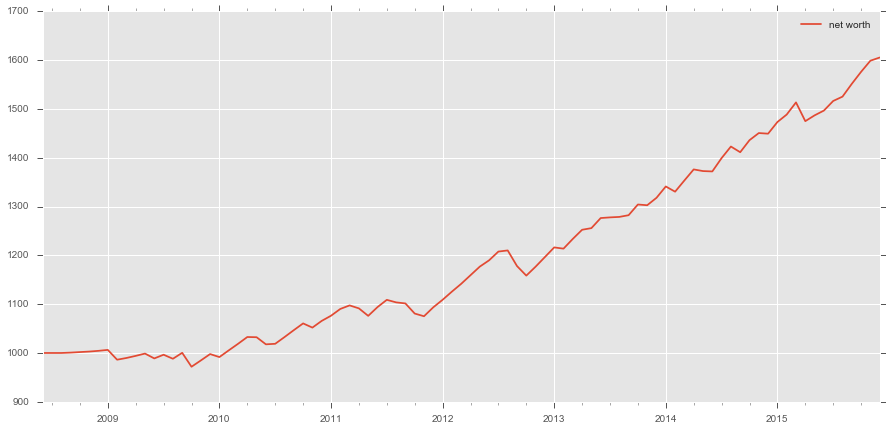

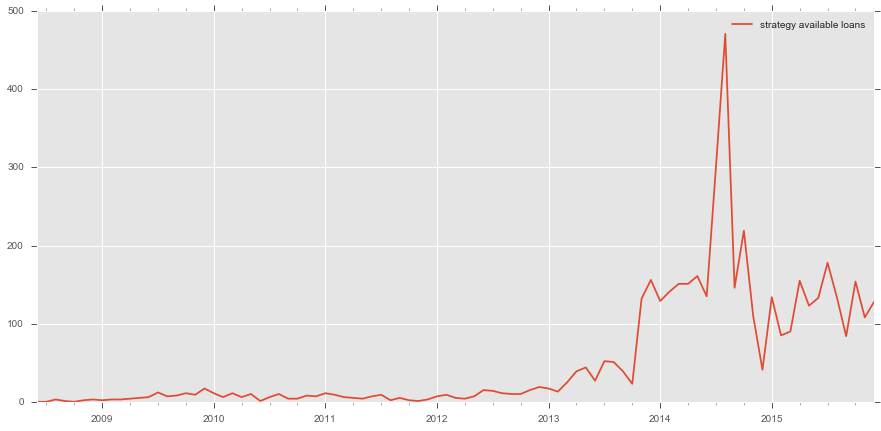

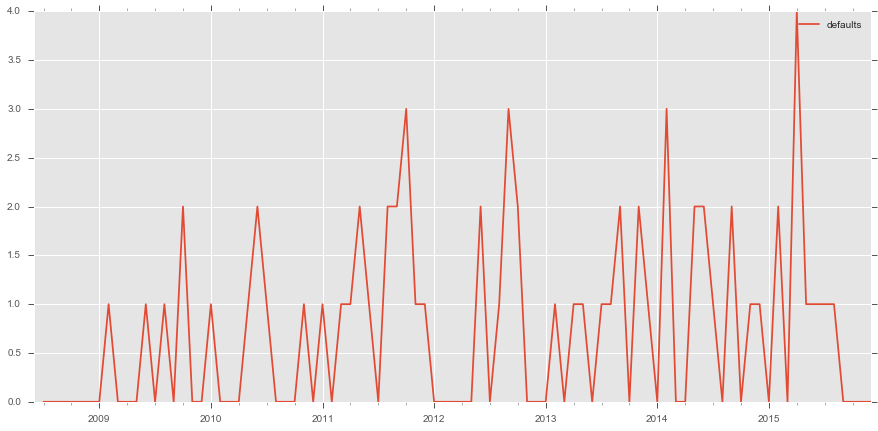

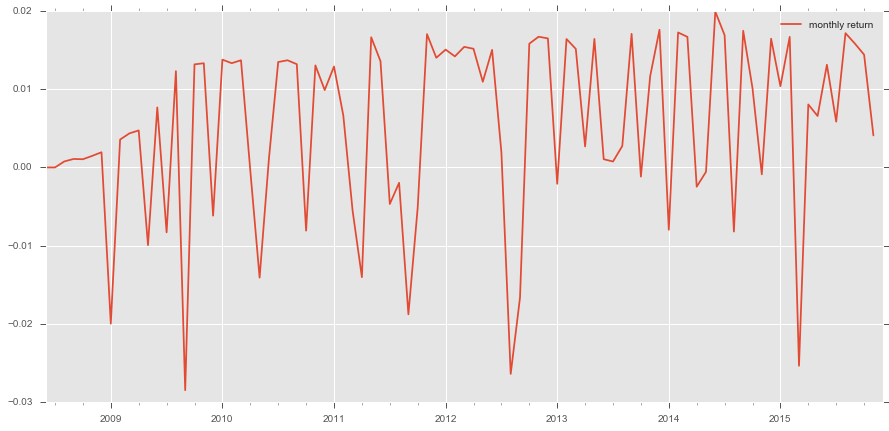

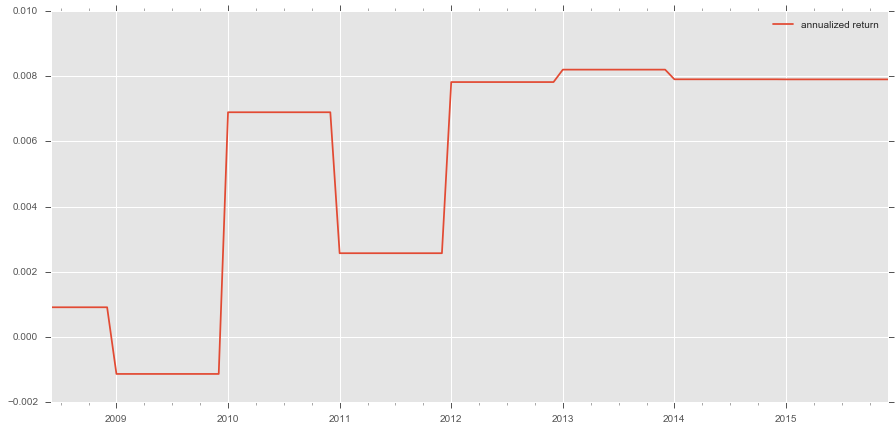

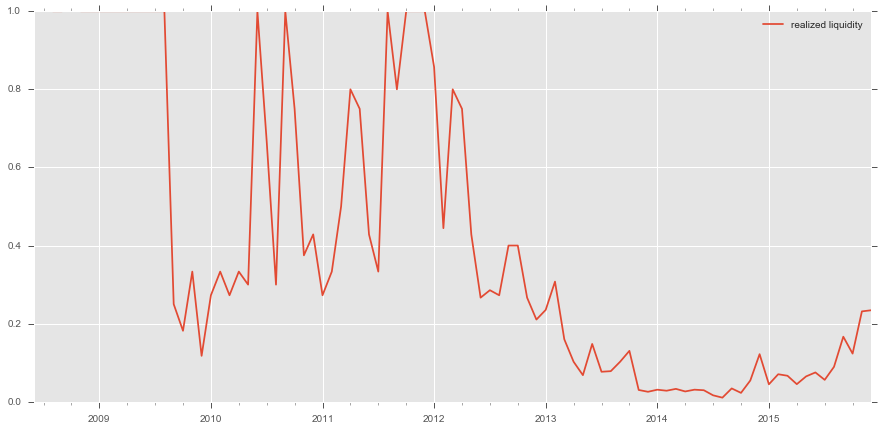

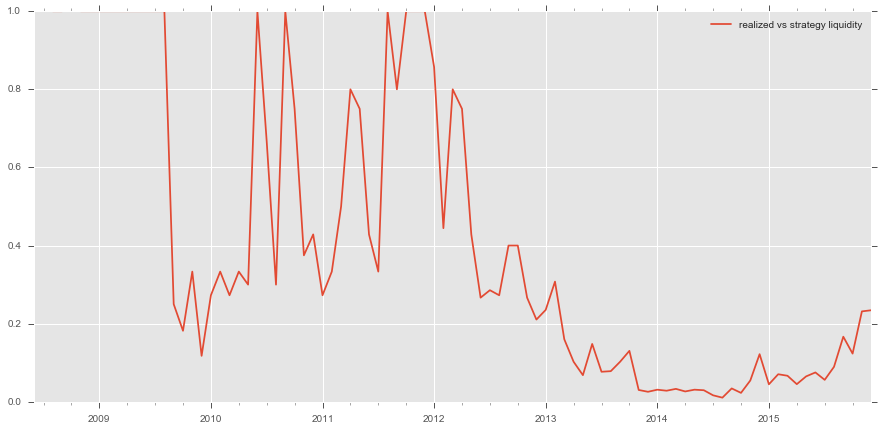

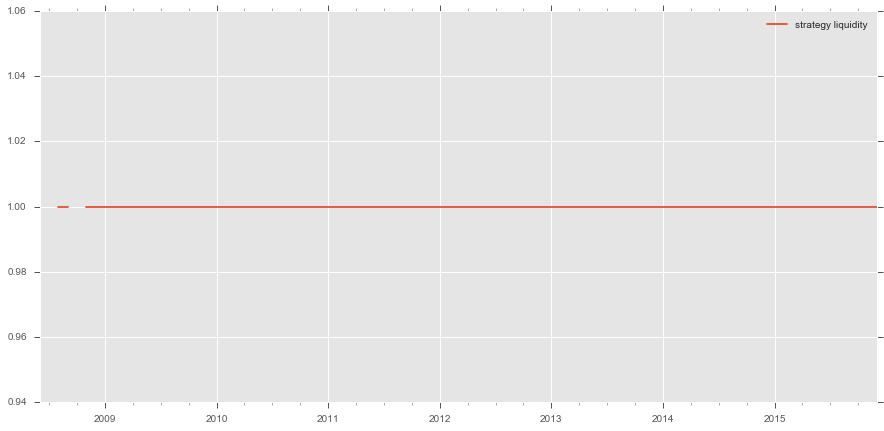

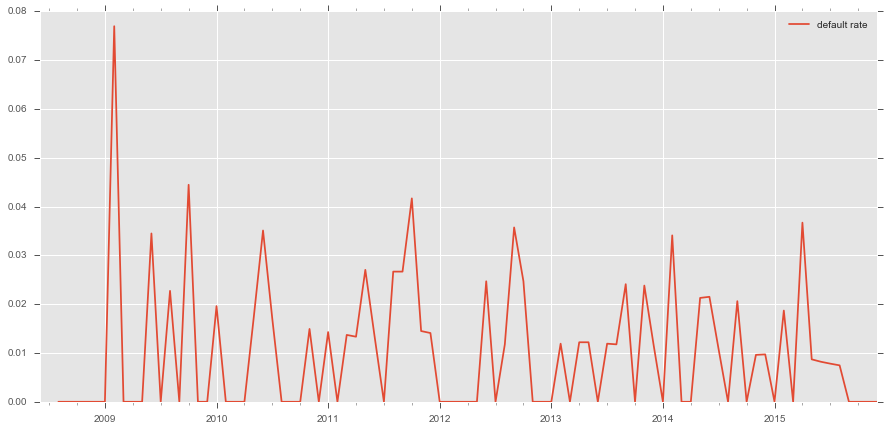

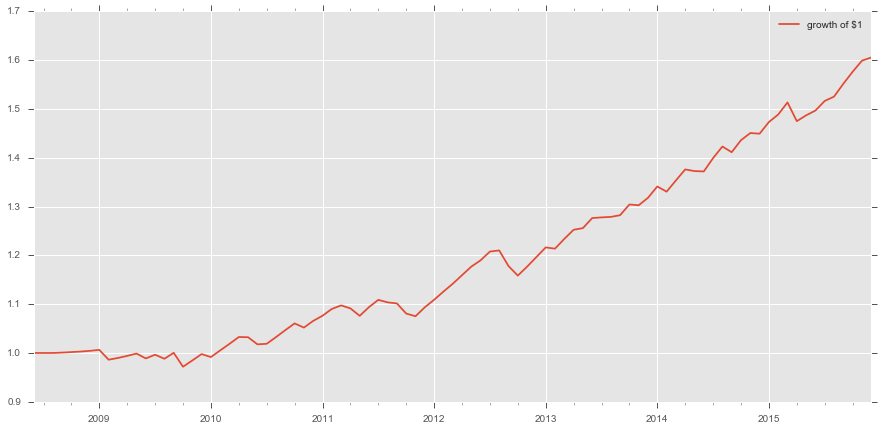

In [43]:
for column in bt.stats.columns:
    bt.stats[column].plot(label=column)
    plt.legend()
    plt.show()

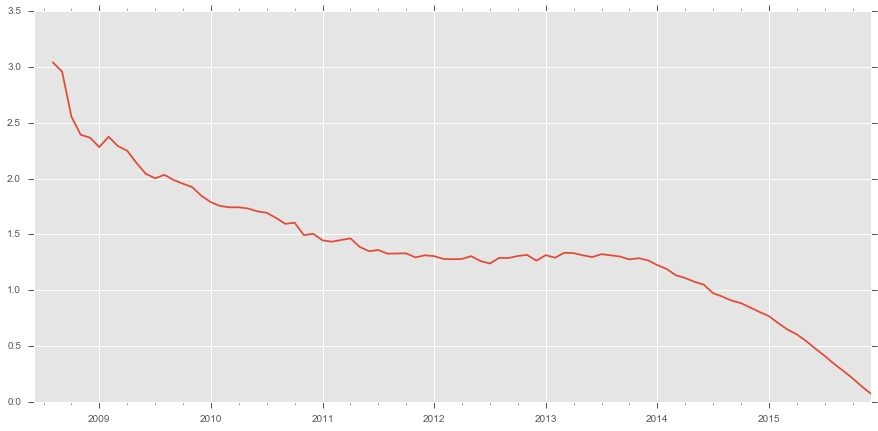

In [29]:
bt.loan_stats['duration'].mean(axis=1).plot()

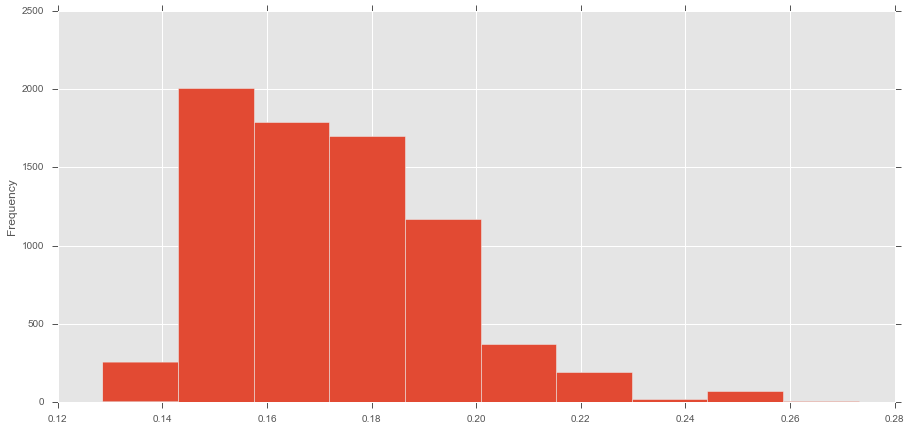

In [30]:
bt.loan_stats_total['int_rate'].plot.hist()

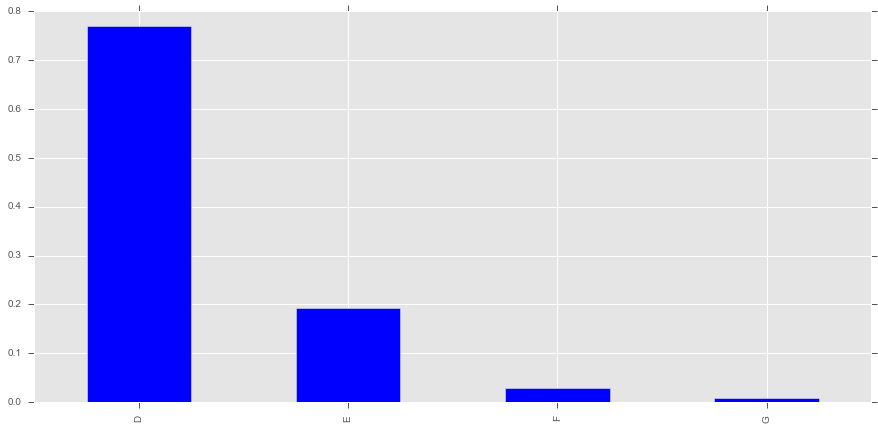

In [31]:
(bt.loan_stats_total['grade'] / bt.loan_stats_total['grade'].sum()).plot.bar()